# Software Requirements Classification
## KNN - K Nearest Neighbors

In [121]:
import pandas as pd

df = pd.read_csv('software_requirements_extended.csv')
df['Type'] = df['Type'].apply(lambda x: 1 if x == 'FR' or x == 'F' else 0)

In [122]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nickbres/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/nickbres/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [123]:
# Pre-load stopwords to improve efficiency
STOPWORDS = set(stopwords.words("english"))

# Expanded pattern to potentially keep useful punctuation or additional cleaning
pattern_without_numbers = re.compile(r"[^a-zA-Z]")
pattern_with_numbers = re.compile(r"[^\w\d]")

def req_to_words(req, delete_stopwords, with_numbers, normalize_numbers,lemmatize = False,stemming = False,):
    """Convert requirement text into a sequence of 'clean' words"""
    # Convert to lower case
    text = req.lower()

    if with_numbers:
        pattern = pattern_with_numbers
    else:
        pattern = pattern_without_numbers

    if with_numbers and normalize_numbers:
        text = re.sub(r'\b\d+\b', 'num', text)

    # Remove unwanted characters
    text = re.sub(pattern, " ", text)

    # Tokenize
    words = text.split()

    # Remove stopwords
    if delete_stopwords:
        words = [w for w in words if w not in STOPWORDS]

    # Apply lemmatization or stemming
    if lemmatize:
        words = [ WordNetLemmatizer().lemmatize(w) for w in words]
    elif stemming: # Stemming
        words = [PorterStemmer().stem(w) for w in words]

    # join the words back into one string
    clean_req = " ".join(words)

    return clean_req

In [124]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

### Model

In [136]:
from sklearn.model_selection import GridSearchCV

def find_best_hyperparameters(X,y):
    param_grid = {
        'n_neighbors': [1,3, 5, 7, 10, 15],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'chebyshev']
    }
    
    grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, verbose=2, n_jobs=-1, scoring='accuracy')
    
    grid_search.fit(X, y)
    
    print("Best parameters:", grid_search.best_params_)
    print("Best cross-validated score:", grid_search.best_score_)
    return grid_search.best_params_, grid_search.best_score_

In [126]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def draw_confusion_matrix(y_test, y_pred):
    # Compute the normalized confusion matrix
    cm_normalized = confusion_matrix(y_test, y_pred, normalize='true')

    # Convert to percentage
    cm_percentage = cm_normalized * 100

    # Visualize the confusion matrix as percentages
    plt.figure(figsize=(10,7))
    sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=['Non-Functional', 'Functional'], yticklabels=['Non-Functional', 'Functional'])
    plt.title('Confusion Matrix (Percentage)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [127]:
def run_experiment(df, preprocessing_params,isVisualize = True):
    """
    Run an experiment to train a logistic regression model with the best hyperparameters found using grid search.
    Evaluates the model using cross-validation and on a test set, and displays the model's important features and confusion matrix.

    Parameters:
    - df: DataFrame containing the dataset.
    - preprocessing_params: Dictionary containing preprocessing parameters (lemmatize, delete_stopwords, normalize_numbers, etc.).
    - ngram_range: Tuple indicating the range of n-grams to be used in vectorization.
    """
    # Extract preprocessing parameters
    lemmatize = preprocessing_params.get('lemmatize', False)
    stemming = preprocessing_params.get('stemming', False)
    delete_stopwords = preprocessing_params.get('delete_stopwords', True)
    with_numbers = preprocessing_params.get('with_numbers', True)
    normalize_numbers = preprocessing_params.get('normalize_numbers', True)

    # Prepare the data
    y = df['Type']
    # Preprocess the requirements to convert them into 'clean' words
    X = [req_to_words(req, lemmatize=lemmatize,stemming= stemming, delete_stopwords=delete_stopwords, with_numbers=with_numbers, normalize_numbers=normalize_numbers) for req in df['Requirement']]


    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Vectorize the text
    vectorizer = TfidfVectorizer()
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)

    # Find the best model parameters
    best_params,best_cross = find_best_hyperparameters(X_train, y_train)

    # Create the best estimator
    best_estimator = KNeighborsClassifier(**best_params)

    # Train the best estimator on the full training set
    best_estimator.fit(X_train, y_train)

    # Evaluate on the test set
    y_pred = best_estimator.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    if isVisualize:
        print(f'Accuracy: {test_accuracy * 100:.2f}%')

        # Detailed performance report
        print(classification_report(y_test, y_pred))

        # Additional evaluations
        draw_confusion_matrix(y_test, y_pred)
        
    return best_estimator, vectorizer, best_cross

### Experimenting

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
Best cross-validated score: 0.8507084585659082
Accuracy: 87.76%
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       131
           1       0.89      0.89      0.89       163

    accuracy                           0.88       294
   macro avg       0.88      0.88      0.88       294
weighted avg       0.88      0.88      0.88       294


/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning:


60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/nickbres/anaconda3/envs/SoftwareRequireme

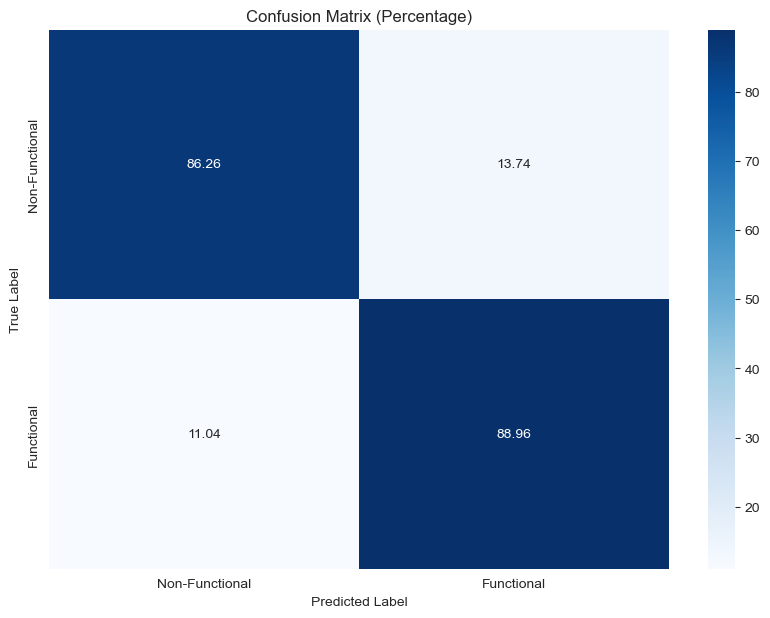

In [137]:
preprocessing_params = {
    'lemmatize': True, # use lemmatization false by default
    'stemming': False, # use stemming false by default
    'delete_stopwords': False, # delete stopwords like 'the', 'and', etc.
    'with_numbers': True, # keep numbers or not
    'normalize_numbers': True # normalize numbers to a single token (will only work if with_numbers is True)
}
model, vectorizer, cross = run_experiment(df, preprocessing_params)

In [129]:
from itertools import product

def find_best_cleaning_params(df):
    """
    Try all combinations of cleaning parameters and return the combination
    with the highest cross-validation score.
    """
    best_score = 0
    best_params = {}

    # Generate all possible combinations of boolean values for the parameters
    # There are five parameters, so there are 2^5 = 32 possible combinations
    for lemmatize, stemming, delete_stopwords, with_numbers, normalize_numbers in product([True, False], repeat=5):

        # Skip invalid combinations where we attempt to normalize numbers when they are not included
        if normalize_numbers and not with_numbers:
            continue

        # Set up the preprocessing parameters
        preprocessing_params = {
            'lemmatize': lemmatize,
            'stemming': stemming,
            'delete_stopwords': delete_stopwords,
            'with_numbers': with_numbers,
            'normalize_numbers': normalize_numbers
        }

        # Run the experiment with the current combination of parameters
        _, _, best_cross = run_experiment(df, preprocessing_params, isVisualize = False)

        # Update best score and parameters if current score is higher
        if best_cross > best_score:
            best_score = best_cross
            best_params = preprocessing_params

    return best_params, best_score

In [130]:
best_params, best_score = find_best_cleaning_params(df)
print("Best parameters:", best_params)
print("Best cross-validation score:", best_score)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits


/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning:


60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/nickbres/anaconda3/envs/SoftwareRequireme

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning:


60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/nickbres/anaconda3/envs/SoftwareRequireme

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning:


60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/nickbres/anaconda3/envs/SoftwareRequireme

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning:


60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/nickbres/anaconda3/envs/SoftwareRequireme

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning:


60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/nickbres/anaconda3/envs/SoftwareRequireme

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits


/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning:


60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/nickbres/anaconda3/envs/SoftwareRequireme

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning:


60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/nickbres/anaconda3/envs/SoftwareRequireme

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning:


60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/nickbres/anaconda3/envs/SoftwareRequireme

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning:


60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/nickbres/anaconda3/envs/SoftwareRequireme

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning:


60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/nickbres/anaconda3/envs/SoftwareRequireme

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning:


60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/nickbres/anaconda3/envs/SoftwareRequireme

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning:


60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/nickbres/anaconda3/envs/SoftwareRequireme

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning:


60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/nickbres/anaconda3/envs/SoftwareRequireme

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning:


60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/nickbres/anaconda3/envs/SoftwareRequireme

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning:


60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/nickbres/anaconda3/envs/SoftwareRequireme

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning:


60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/nickbres/anaconda3/envs/SoftwareRequireme

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits


/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning:


60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/nickbres/anaconda3/envs/SoftwareRequireme

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END ..metric=euclidean, n_neighbors=1, weights=distance; total time=   0.1s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=5, weights=distance; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=7, weights=uniform; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=10, weights=uniform; total time=   0.0s
[CV] END ...metric=manhattan, n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END ...metric=manhattan, n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END ...metric=manhattan, n_neighbors=5, weights=uniform; total time=   0.0s
[CV] END ..metric=manhattan, n_neighbors=5, weights=distance; total time=   0.0s
[CV] END .metric=manhattan, n_neighbors=15, weights=distance; total time=   0.0s
[CV] END .metric=manhattan, n_neighbors=15, weights=distance; tota

/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning:


60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/nickbres/anaconda3/envs/SoftwareRequireme

[CV] END ..metric=euclidean, n_neighbors=1, weights=distance; total time=   0.1s
[CV] END ...metric=euclidean, n_neighbors=5, weights=uniform; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=5, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=7, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=10, weights=uniform; total time=   0.0s
[CV] END ...metric=manhattan, n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END ..metric=manhattan, n_neighbors=1, weights=distance; total time=   0.0s
[CV] END ..metric=manhattan, n_neighbors=3, weights=distance; total time=   0.0s
[CV] END ..metric=manhattan, n_neighbors=3, weights=distance; total time=   0.0s
[CV] END ..metric=manhattan, n_neighbors=7, weights=distance; total time=   0.0s
[CV] END ..metric=manhattan, n_neighbors=7, weights=distance; total time=   0.0s
[CV] END ..metric=manhattan, n_neighbors=10, weights=uniform; total time=   0.0s
[CV] END ..metric=manhattan,

/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning:


60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/nickbres/anaconda3/envs/SoftwareRequireme

[CV] END ..metric=euclidean, n_neighbors=1, weights=distance; total time=   0.1s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=5, weights=distance; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=7, weights=uniform; total time=   0.0s
[CV] END .metric=euclidean, n_neighbors=10, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=15, weights=uniform; total time=   0.0s
[CV] END .metric=euclidean, n_neighbors=15, weights=distance; total time=   0.0s
[CV] END ...metric=manhattan, n_neighbors=3, weights=uniform; total time=   0.0s
[CV] END ..metric=manhattan, n_neighbors=3, weights=distance; total time=   0.0s
[CV] END .metric=manhattan, n_neighbors=10, weights=distance; total time=   0.0s
[CV] END .metric=manhattan, n_neighbors=10, weights=distance; total time=   0.0s
[CV] END .metric=manhattan, n_neighbors=10, weights=distance; total time=   0.0s
[CV] END .metric=manhattan, 

/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning:


60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/nickbres/anaconda3/envs/SoftwareRequireme

### Manually testing the model
Using my own examples to see how the model performs on them instead of using the test set

In [131]:
def predict_req(req, expected, model, vectorizer, preprocessing_params):
    df = pd.DataFrame([req], columns=['Requirement'])

    lemmatize = preprocessing_params.get('lemmatize', True)
    delete_stopwords = preprocessing_params.get('delete_stopwords', True)
    with_numbers = preprocessing_params.get('with_numbers', True)
    normalize_numbers = preprocessing_params.get('normalize_numbers', True)

    X = [req_to_words(req, lemmatize=lemmatize, delete_stopwords=delete_stopwords, with_numbers=with_numbers, normalize_numbers=normalize_numbers) for req in df['Requirement']]
    X = vectorizer.transform(X)

    prediction = model.predict(X)
    predicted_label = 'Functional' if prediction[0] == 1 else 'Non-Functional'
    success = predicted_label == expected

    return predicted_label, success


In [132]:
def summarize_predictions(examples, model, vectorizer , preprocessing_params):
    results = []
    for req, expected_label in examples:
        predicted_label, success = predict_req(req, expected_label, model, vectorizer, preprocessing_params)
        results.append({
            'Requirement': req,
            'Expected Label': expected_label,
            'Predicted Label': predicted_label,
            'Success': success
        })
    return pd.DataFrame(results)

In [133]:
examples = [
    ("The system shall provide a login form that accepts a username and password.", 'Functional'),
    ("The application must ensure that response times are less than 2 seconds under normal load conditions.", 'Non-Functional'),
    ("All user passwords shall be encrypted before saving to the database.", 'Functional'),
    ("The software should be compatible with the Windows 10 operating system.", 'Non-Functional'),
    ("The interface shall refresh when new data is available.", 'Functional'),
    ("The product shall comply with international accessibility standards.", 'Non-Functional'),
    ("Database backup shall occur every 24 hours automatically.", 'Functional'),
    ("The system shall support a minimum of 500 concurrent user connections.", 'Functional'),
    ("The system’s mean time to failure shall be at least 10,000 hours.", 'Non-Functional'),
    ("Users must be able to complete the primary workflow in less than three minutes.", 'Non-Functional'),
    ("User settings must be retained for at least one year without login.", 'Non-Functional'),
    ("The system must support multi-language interfaces.", 'Functional'),
    ("Ensure data integrity during transaction processing.", 'Functional'),
    ("The application should load the user dashboard within 3 seconds.", 'Non-Functional'),
    ("Support data export to CSV and PDF formats.", 'Functional'),
    ("Must be compatible with both iOS and Android operating systems.", 'Non-Functional'),
    ("Implement two-factor authentication for user logins.", 'Functional'),
    ("The application must be available 99.9% of the time.", 'Non-Functional'),
    ("Automatically log out users after 30 minutes of inactivity.", 'Functional'),
    ("The system must scale to support up to 10,000 users simultaneously.", 'Non-Functional'),
    ("Provide a way to recover forgotten passwords securely.", 'Functional'),
    ("The system must encrypt sensitive data both at rest and in transit.", 'Non-Functional'),
    ("Support for user roles including admin, editor, and viewer.", 'Functional'),
    ("Ensure the application interface adheres to the latest web accessibility guidelines.", 'Non-Functional'),
    ("The software must be installable on both Windows and MacOS.", 'Non-Functional'),
    ("Offer a search function that returns results within 2 seconds.", 'Functional'),
    ("The mobile app should use no more than 50MB of data per hour of activity.", 'Non-Functional'),
    ("The platform must integrate seamlessly with third-party email services.", 'Functional'),
    ("User feedback must be addressed and incorporated within two release cycles.", 'Non-Functional'),
    ("Provide detailed logging of user actions to support auditing requirements.", 'Functional')
]


In [134]:
summary = summarize_predictions(examples, model, vectorizer, preprocessing_params)
summary

,Requirement,Expected Label,Predicted Label,Success
0,The system shall provide a login form that acc...,Functional,Functional,True
1,The application must ensure that response time...,Non-Functional,Non-Functional,True
2,All user passwords shall be encrypted before s...,Functional,Non-Functional,False
3,The software should be compatible with the Win...,Non-Functional,Non-Functional,True
4,The interface shall refresh when new data is a...,Functional,Non-Functional,False
5,The product shall comply with international ac...,Non-Functional,Non-Functional,True
6,Database backup shall occur every 24 hours aut...,Functional,Non-Functional,False
7,The system shall support a minimum of 500 conc...,Functional,Non-Functional,False
8,The system’s mean time to failure shall be at ...,Non-Functional,Non-Functional,True
9,Users must be able to complete the primary wor...,Non-Functional,Non-Functional,True


In [135]:
import plotly.express as px

fig = px.pie(summary, names='Success', title ='Success of the model on my examples')
fig.show()